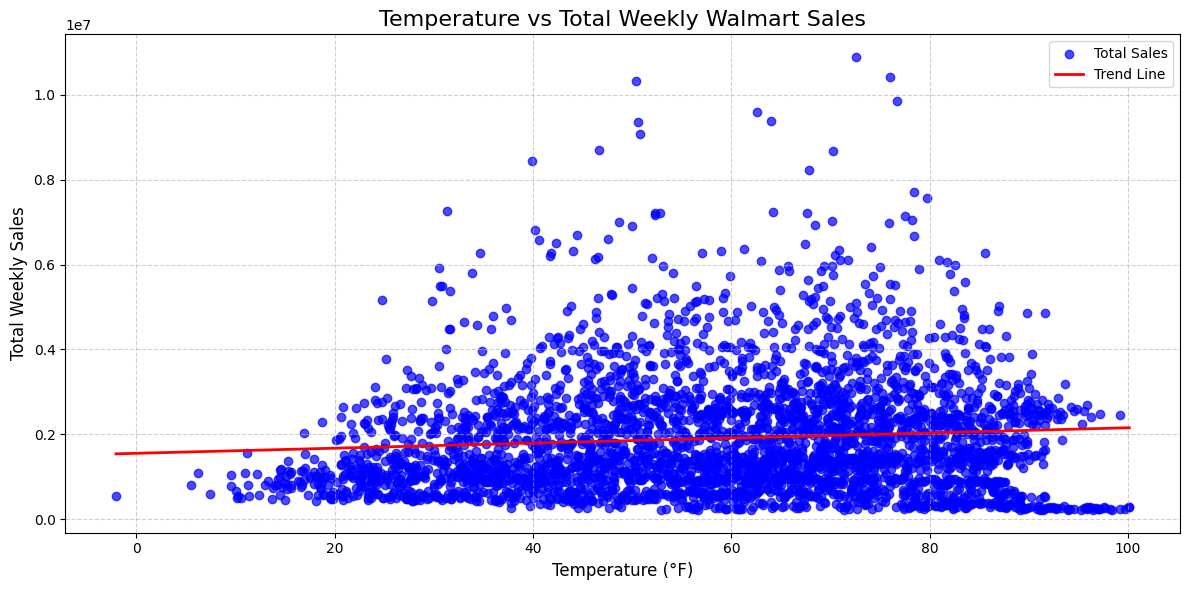

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Replace with your file path
file_path = '/content/Walmart.csv'

# Load the data
data = pd.read_csv(file_path)

# Convert the 'Date' column to a datetime format with dayfirst=True
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')

# Drop rows where the date conversion failed (e.g., invalid dates)
data = data.dropna(subset=['Date'])

# Group by temperature and sum sales for all stores
temperature_sales = data.groupby('Temperature')['Weekly_Sales'].sum()

# Plot the data as a dot plot
plt.figure(figsize=(12, 6))
plt.scatter(temperature_sales.index, temperature_sales.values, color='blue', alpha=0.7, label='Total Sales')

# Fit a linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(temperature_sales.index, temperature_sales.values)
regression_line = slope * temperature_sales.index + intercept

# Plot the regression line
plt.plot(temperature_sales.index, regression_line, color='red', linewidth=2, label='Trend Line')

# Customize the plot
plt.title('Temperature vs Total Weekly Walmart Sales', fontsize=16)
plt.xlabel('Temperature (°F)', fontsize=12)
plt.ylabel('Total Weekly Sales', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


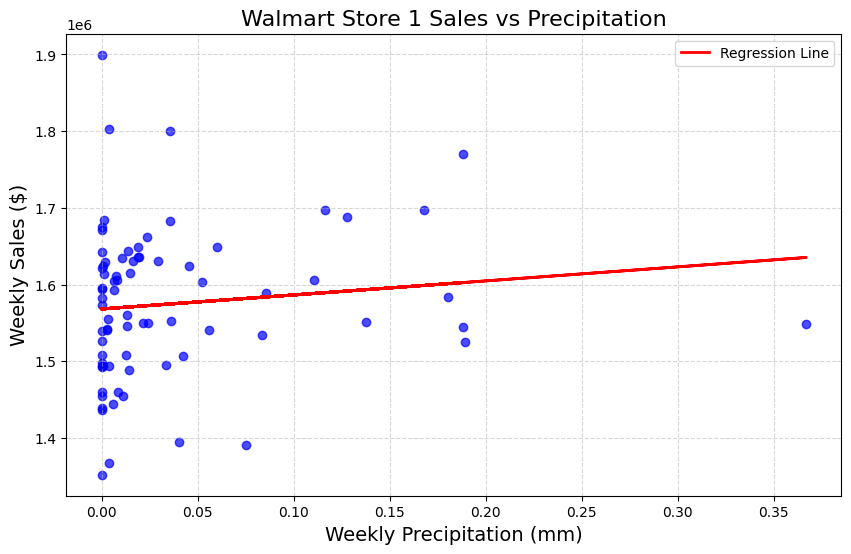

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the datasets
walmart_file_path = '/content/Walmart.csv'
weather_file_path = '/content/Colorado 2010-05-02 to 2012-11-01.csv'

# Read the Walmart data
walmart_data = pd.read_csv(walmart_file_path)

# Read the Weather data
weather_data = pd.read_csv(weather_file_path)

# Filter Walmart data for Store 1
store_1_data = walmart_data[walmart_data['Store'] == 1].copy()

# Convert Date columns to datetime, handling errors
store_1_data['Date'] = pd.to_datetime(store_1_data['Date'], dayfirst=True, errors='coerce')
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'], dayfirst=True, errors='coerce')

# Drop rows with invalid dates
store_1_data.dropna(subset=['Date'], inplace=True)
weather_data.dropna(subset=['datetime'], inplace=True)

# Ensure 'precip' is numeric and drop non-numeric values
if 'precip' in weather_data.columns:
    weather_data['precip'] = pd.to_numeric(weather_data['precip'], errors='coerce')

# Drop non-numeric columns from weather data
numeric_weather_data = weather_data.select_dtypes(include='number').copy()
numeric_weather_data['datetime'] = weather_data['datetime']

# Resample Store 1 data by week to get weekly sales
store_1_weekly = store_1_data.resample('W-Mon', on='Date').sum().reset_index()

# Resample numeric weather data by week to get weekly precipitation
weather_weekly = numeric_weather_data.resample('W-Mon', on='datetime').mean().reset_index()

# Merge the two datasets on the week
merged_data = pd.merge(
    store_1_weekly,
    weather_weekly,
    left_on='Date',
    right_on='datetime',
    how='inner'
)

# Drop any rows with NaN or infinite values in the relevant columns
merged_data = merged_data[np.isfinite(merged_data['precip']) & np.isfinite(merged_data['Weekly_Sales'])]

# Create the dot plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['precip'], merged_data['Weekly_Sales'], alpha=0.7, color='blue')
plt.title('Walmart Store 1 Sales vs Precipitation', fontsize=16)
plt.xlabel('Weekly Precipitation (mm)', fontsize=14)
plt.ylabel('Weekly Sales ($)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# Add a regression line
if len(merged_data['precip']) > 1:  # Ensure there is more than one point for a fit
    coefficients = np.polyfit(merged_data['precip'], merged_data['Weekly_Sales'], 1)
    regression_line = np.poly1d(coefficients)
    plt.plot(merged_data['precip'], regression_line(merged_data['precip']), color='red', linewidth=2, label='Regression Line')
    # Display the legend
    plt.legend()
else:
    print("Not enough data to fit a regression line.")

plt.show()


<Figure size 1200x600 with 0 Axes>

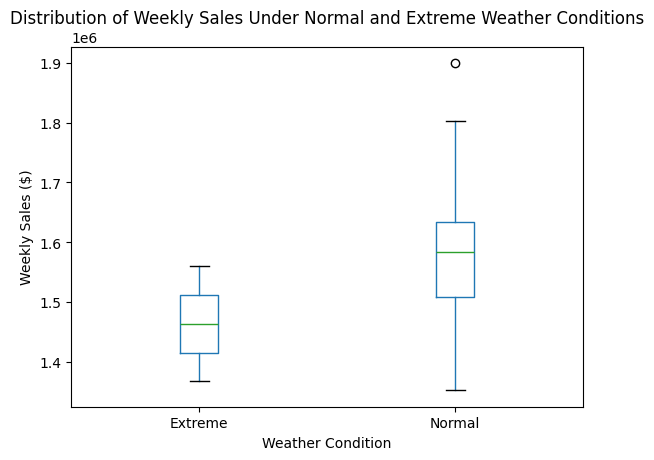

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the extreme weather conditions
extreme_conditions = (
    (merged_data['precip'] > 0.7) |
    (merged_data['windspeed'] > 50) |
    (merged_data['visibility'] < 5) |
    (merged_data['tempmin'] < 10)
)

# Create a new column to label data as 'Extreme' or 'Normal'
merged_data['Weather Condition'] = np.where(extreme_conditions, 'Extreme', 'Normal')

# Boxplot for weekly sales under normal vs extreme weather conditions
plt.figure(figsize=(12, 6))
merged_data.boxplot(column='Weekly_Sales', by='Weather Condition', grid=False)
plt.title('Distribution of Weekly Sales Under Normal and Extreme Weather Conditions')
plt.suptitle('')  # Remove the default subtitle
plt.xlabel('Weather Condition')
plt.ylabel('Weekly Sales ($)')
plt.show()


Mean Squared Error (MSE): 3785396113.69
R-squared (R²): 0.49
Model Coefficients: [-68398.74022196   6519.34156816  -3417.9787471    3732.81036036]
Model Intercept: 1398329.2244816208


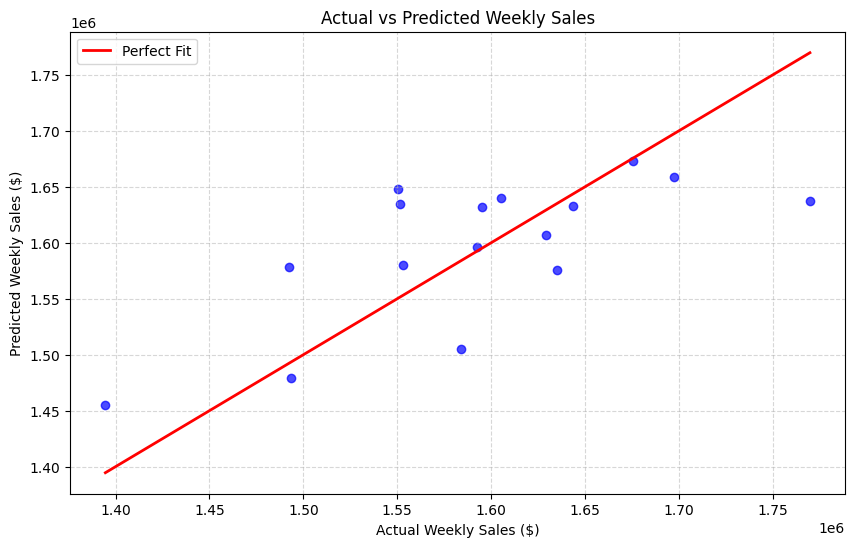

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define the features and target variable
features = ['precip', 'windspeed', 'visibility', 'tempmin']
target = 'Weekly_Sales'

# Drop rows with NaN values in the relevant columns
merged_data = merged_data.dropna(subset=features + [target])

# Define X (features) and y (target)
X = merged_data[features]
y = merged_data[target]

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'R-squared (R²): {r2:.2f}')

# Print the model coefficients and intercept
print('Model Coefficients:', model.coef_)
print('Model Intercept:', model.intercept_)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label='Perfect Fit')
plt.title('Actual vs Predicted Weekly Sales')
plt.xlabel('Actual Weekly Sales ($)')
plt.ylabel('Predicted Weekly Sales ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


<ipython-input-62-cbfbe8e6f8d4>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=holiday_sales.index.map({True: 'Holiday', False: 'Non-Holiday'}), y=holiday_sales['mean'], palette='viridis')


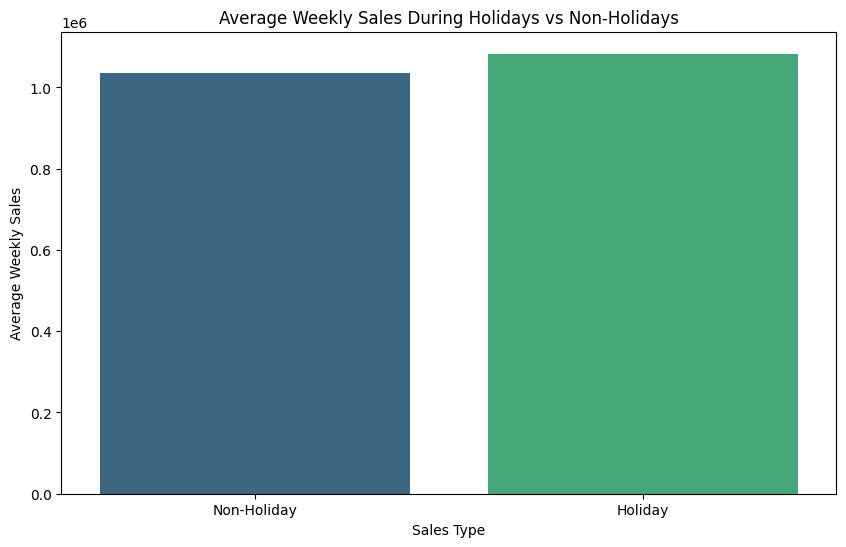

<ipython-input-62-cbfbe8e6f8d4>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Is_Holiday', y='Weekly_Sales', data=data, palette='Set2')


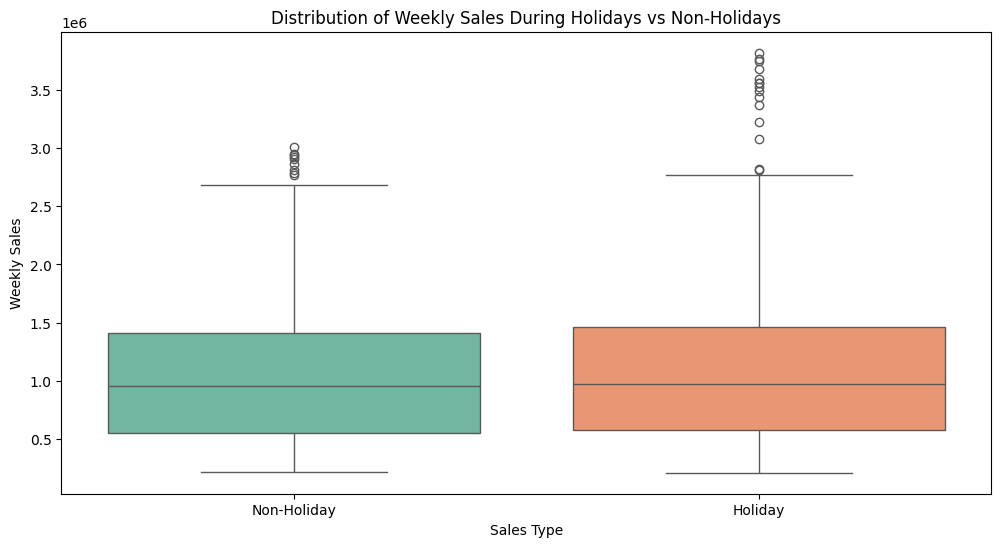

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Replace with your file path
file_path = '/content/Walmart.csv'

# Load the data
data = pd.read_csv(file_path)

# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])

# Ensure 'Weekly_Sales' is numeric
data['Weekly_Sales'] = pd.to_numeric(data['Weekly_Sales'], errors='coerce')
data = data.dropna(subset=['Weekly_Sales'])

# Create a new column to identify holidays
# Assuming you have a column 'Holiday' that indicates whether a date is a holiday (True/False)
# If not, you'll need to create one based on your data or an external holiday list
data['Is_Holiday'] = data['Date'].dt.month.isin([12, 1, 7])  # Example: December, January, July as holidays

# Group data by 'Is_Holiday' and calculate mean and median sales
holiday_sales = data.groupby('Is_Holiday')['Weekly_Sales'].agg(['mean', 'median'])

# Bar plot for average sales during holidays vs non-holidays
plt.figure(figsize=(10, 6))
sns.barplot(x=holiday_sales.index.map({True: 'Holiday', False: 'Non-Holiday'}), y=holiday_sales['mean'], palette='viridis')
plt.title('Average Weekly Sales During Holidays vs Non-Holidays')
plt.xlabel('Sales Type')
plt.ylabel('Average Weekly Sales')
plt.show()

# Box plot for distribution of sales during holidays vs non-holidays
plt.figure(figsize=(12, 6))
sns.boxplot(x='Is_Holiday', y='Weekly_Sales', data=data, palette='Set2')
plt.title('Distribution of Weekly Sales During Holidays vs Non-Holidays')
plt.xlabel('Sales Type')
plt.ylabel('Weekly Sales')
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'])
plt.show()


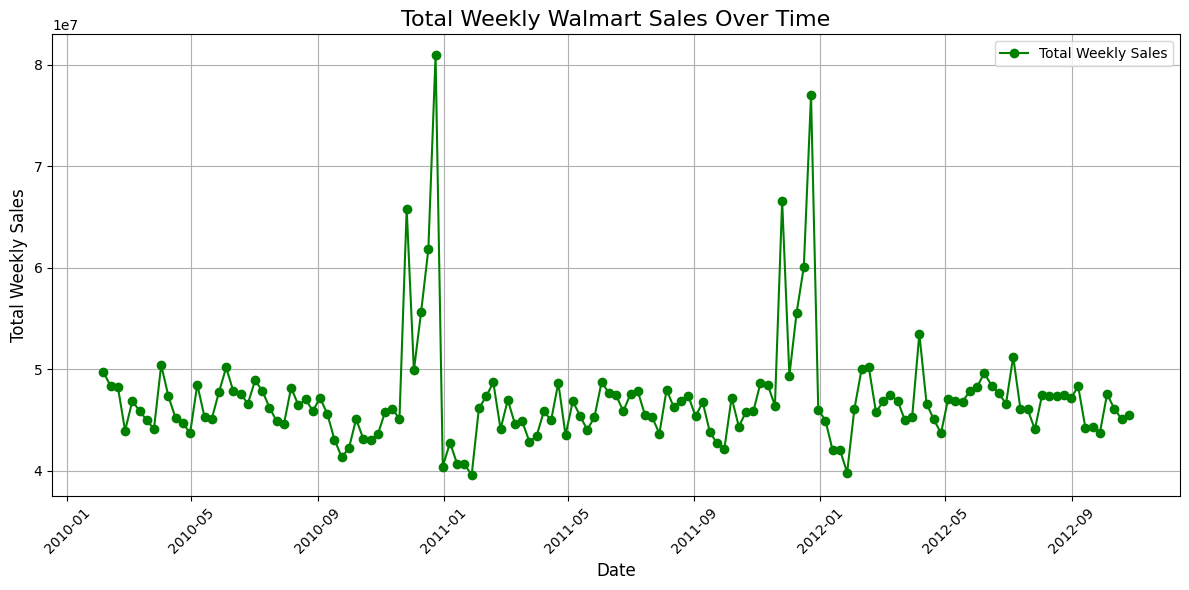

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace with your file path
file_path = '/content/Walmart.csv'

# Load the data
data = pd.read_csv(file_path)

# Convert the 'Date' column to a datetime format with dayfirst=True
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')

# Drop rows where the date conversion failed (e.g., invalid dates)
data = data.dropna(subset=['Date'])

# Group by the date and sum sales for all stores
weekly_sales = data.groupby('Date')['Weekly_Sales'].sum()

# Sort by date (in case it's not sorted)
weekly_sales = weekly_sales.sort_index()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales.index, weekly_sales.values, color='green', marker='o', linestyle='-', label='Total Weekly Sales')

# Customize the plot
plt.title('Total Weekly Walmart Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Weekly Sales', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


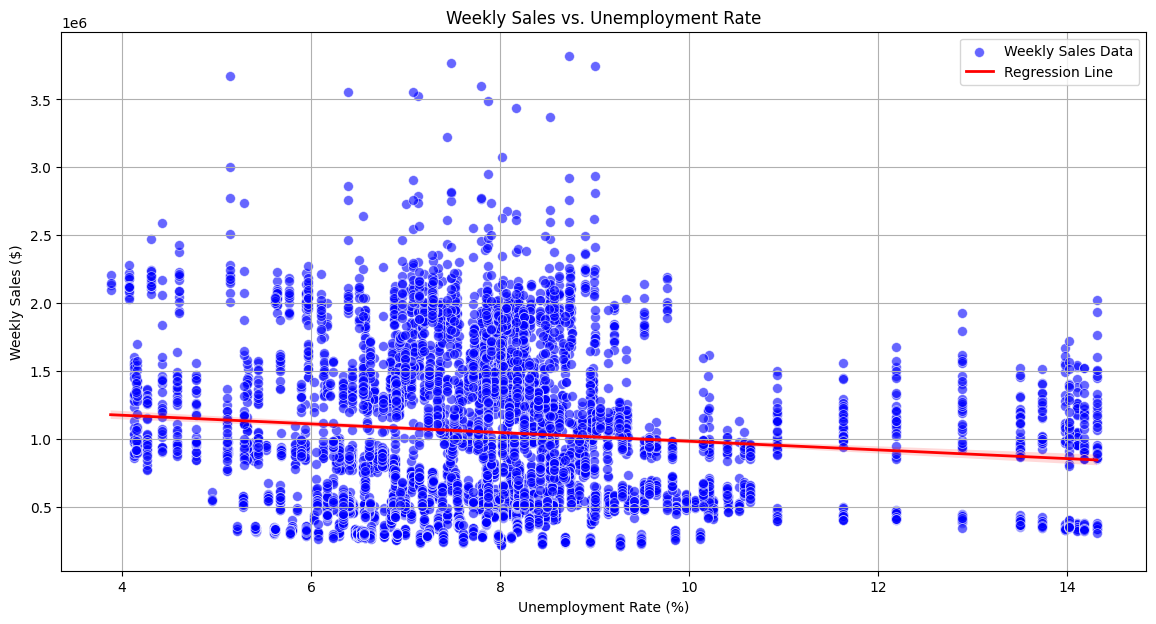

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your DataFrame with the relevant columns:
# 'Date' for the date, 'Weekly_Sales' for the weekly sales, and 'Unemployment' for the unemployment rate.

# Convert the 'Date' column to datetime format if it is not already
data['Date'] = pd.to_datetime(data['Date'])

# Plotting the dot plot for each week with the exact unemployment rate
plt.figure(figsize=(14, 7))
sns.scatterplot(x='Unemployment', y='Weekly_Sales', data=data, color='blue', alpha=0.6, s=50, marker='o', label='Weekly Sales Data')

# Add a regression line to visualize the trend
sns.regplot(x='Unemployment', y='Weekly_Sales', data=data, scatter=False, color='red', line_kws={"linewidth": 2}, label='Regression Line')

# Add title and labels
plt.title('Weekly Sales vs. Unemployment Rate')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Weekly Sales ($)')
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()
